# Dimensionality Reduction

Many ML algorithms involve thousands or even millions of features for each training instance. Not only do all these features make training extremely slow, but they can also make it much harder to find a good solution, as you will see. This problem is often referred to as the _curse of dimensionality_.

Fortunately, in real world, its usually possible to reduce the number of features, considerably, turning an intractable problem into a tractable one. For example, consider the MNIST images (introduced in Chapter 3): the pixels from the image borders are almost always white, so you could completely drop these pixels from the training set without losing much information.
Additionally two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g. by taking the mean of the two pixel intensities), you will not lose much information.


Reducing dimensionality does cause some information loss, just like compressing an image to JPEG can degrade its quality, so even though it will speed up training, it may make your system perform slightly worse. In some cases it may filter out some noise and unnecessary details, and thus result in higher performance, but in general it wont; it will just speed up training.

Apart from speeding up training, dimensionality reduction down to two or three dimensions makes it possible to plot a condensed view of a high-dimensional training set on a graph. This allows us to visually detect patterns such as clusters and gain insights. Also, data visualization is essential to communicate your conclusions to non-tech folks.

In this chapter:-
- we will first discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space.
- then we will consider the two main approaches to dimensionality reduction (projection and manifold learning)
- we will go through three of the most popular dimensionality reduction techniques
  - PCA,
  - random projection
  - locally linear embedding (LLE)

**The Curse of Dimensionality**

It turns out many things behave very differently in a high-dimensional space.
- For example, if you pick a random point in a unit square (a 1 x 1 square), it will only have a 0.4% chance of being less than 0.001 from a border, in other words, it is very unlikely that a random point will be "extreme" along any dimension.
- however in a 10000 dimensional unit hypercube, this probably is greater than 99.9999%. Most points in a high-dimensional hypercube are very close to the border.

Another example, if you pick any two points
- in a unit square, the distance between these two points will be on average, roughly 0.52
- if you pick two random points in a 3D unit cube, the average distance will be roughly 0.66
- in a 1,000,000 dimensional unit hypercube, it will be 408.25. This is counter-intuitive, how can the points be so far apart if they both lie within the same unit hypercube? Well, theres just plenty of space in higher dimensions.
- As a result, high-dimensional datasets are at risk of being very sparse: most training instances are likely to be very far apart form each other.
- This also means that a new instance will likely be very far away from any training instance, making predictions much less reliable than in lower dimensions.
- In short, the more dimensions the training set has, the greater the risk of overfitting it. (we saw this in previous chapters)

In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.

**Main Approaches for Dimensionality Reduction**

Before we dive into specific dimensionality reduction algorithms, lets take a look at the two main approaches to reducing dimensionality: projection and manifold learning.

**Projection**

In most real world problems, training instances are _not_ spread uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. This sounds very abstract, so lets look at an example.

Let's generate a small 3D dataset. It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise:

In [3]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

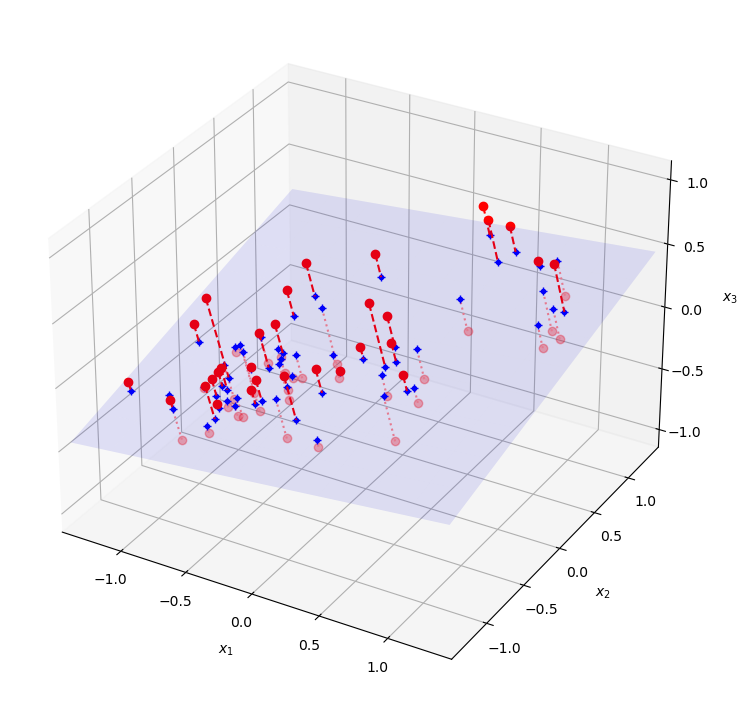

In [4]:
# extra code – this cell generates and saves Figure 8–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

# save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the higher-dimensional (3D) space. If we project every training instance perpendicually on this subspace (represented by the short-dashed lines connecting the instances to the plane), we get the new 2D dataset shown below.

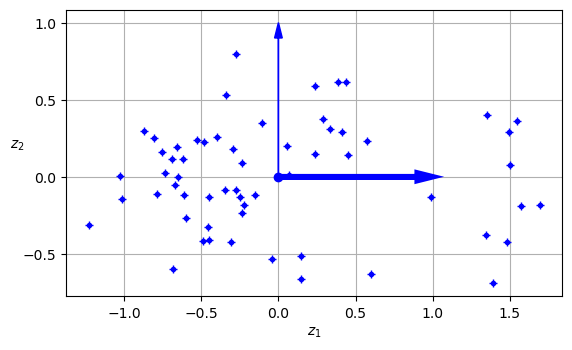

In [5]:
# extra code – this cell generates and saves Figure 8–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
# save_fig("dataset_2d_plot")

Ta-da! We have just reduced the dataset's dimensionality from 3D to 2D. Note that the axes correspond to new features z1 and z2: they are the coordinates of the projections on the plane.

**Manifold Learning**

However, projection is not always the best approach to dimensionality reduction. In many cases, the subspace may twist and turn, such as in the famous Swiss roll toy dataset represented in figure below:-

In [6]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

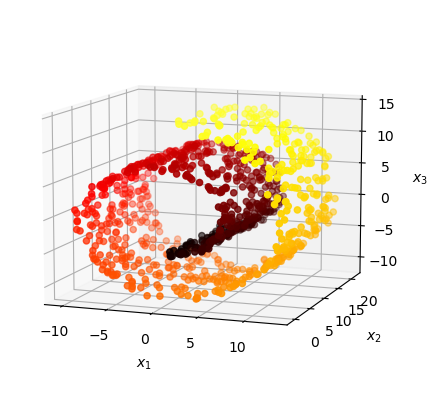

In [7]:
# extra code – this cell generates and saves Figure 8–4

from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
# save_fig("swiss_roll_plot")
plt.show()

Simply projecting onto a plane (e.g. by dropping x3) would squash different layers of the Swiss roll altogether, as shown in left figure below:-

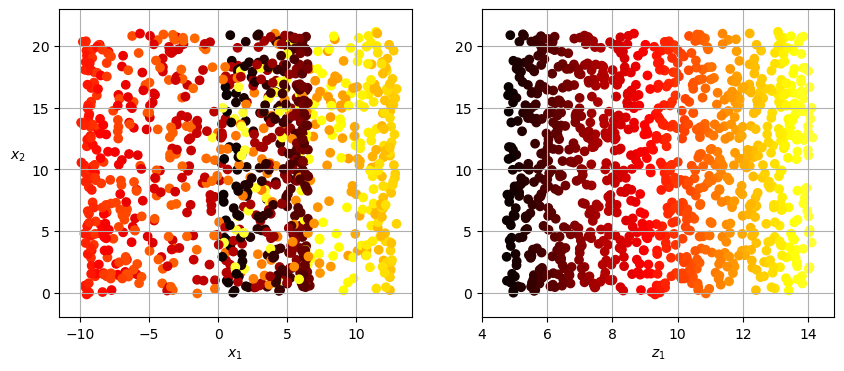

In [8]:
# extra code – this cell generates and saves plots for Figure 8–5

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

# save_fig("squished_swiss_roll_plot")
plt.show()

What you probably want instead is to unroll the Swiss roll to obtain the 2D dataset on the right side.

The Swiss roll is an example of a 2D manifold. A 2D manifold is a 2D shape that can be bent and twisted in a higher dimensional space. More generally, a _d_ dimensional manifold is part of an _n_-dimensional space (where _d_ < _n_) that locally resembles a _d_-dimensional hyperplane. In the case of the Swiss roll, _d_=2 and _n_=3: it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling a manifold on which the training instances lie: this is called _manifold_learning_.
- It relies on the _manifold assumption_ or _manifold hypothesis_, that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. This assumption is very often empirically observed.

Once again, think about the MNIST dataset
- all handwritten digits have some similarities
  - they are made of connected lines, the borders are white, and they are mostly centered.
  - If you try to randomly generate images, only a ridiculously tiny number of these would look like handwritten digits.
  - In other words, these constraints squeeze the dataset into a lower-dimensional manifold

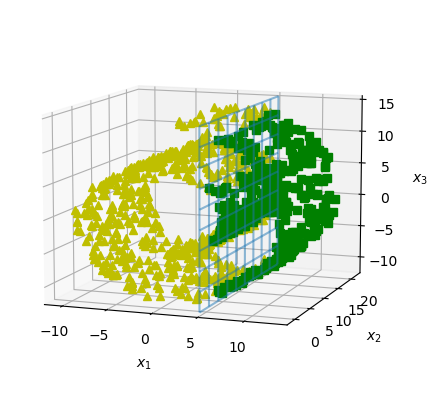

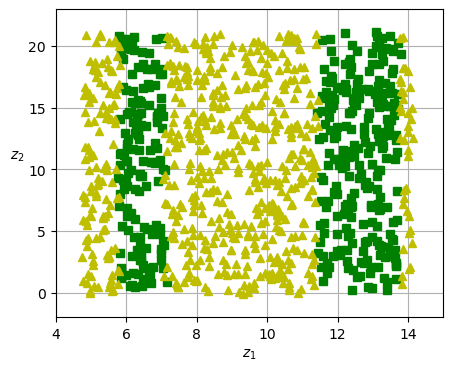

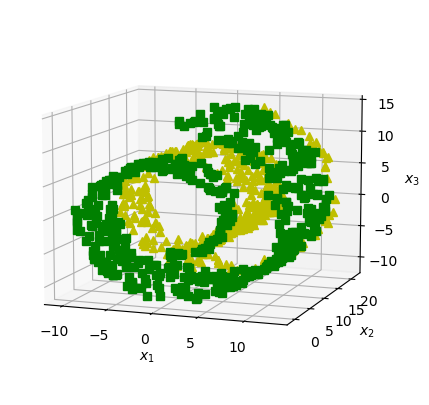

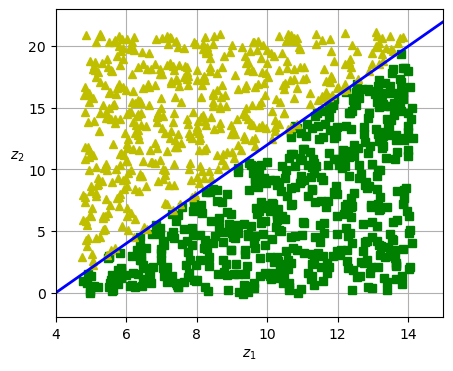

In [9]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
# save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
# save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
# save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
# save_fig("manifold_decision_boundary_plot4")
plt.show()

- another implicit assumption is that the task at hand (classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.
  - for e.g. in last two plots of figure above, the decision boundary for the roll is tough to get than the one for the unrolled plot
  - however this does not always hold as shown in the first two plots, the decision boundary for the 2D manifold is more complex

In short, reducing dimensionality of your training set before training a model will usually speed up training, but it may not always lead to a better or simpler solution; it all depends on the dataset.

The rest of this chapter will go through some of the most popular algorithms for dimensionality reduction.

**PCA**

_Principal component analysis (PCA)_ is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

**Preserving the Variance**

Before you can project the training set onto a lower-D hyperplane, you first need to choose the right hyperplane. 

For example, a simple 2D dataset is represented on the left in figure below

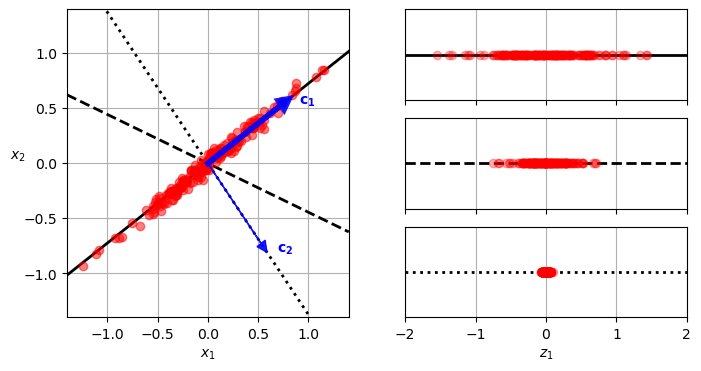

In [10]:
# extra code – this cell generates and saves Figure 8–7

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

# save_fig("pca_best_projection_plot")
plt.show()

On the right is the result of the projection of the dataset onto each of these axes. As you can see
- the top projection (the projection onto the solid line) preserves maximum variance
- the bottom project (onto the dotted line) preserves very little variance
- the middle projection (onto the dashed line) preserves an intermediate amount

So our goal is to select the axis the preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Also this minimizes the meane squared distance between the original dataset and the projection onto that axis

**Principal Components**

PCA identifies the axis that accounts for the largest amount of variance in the training set
- in figure above, its the solid line
- it also finds a second axis, orthogonal to the first one, that accounts for the alrgest amount of remaining variance. 
  - In this case theres no choice, only the dotted line is orthogonal
- if there were more dimensions, it could also find a third axis, orthogonal to the previous axes
  - and so on - as many axes as there are the number of dimensions in the dataset.
  
- the $i^{th}$ axis is called the $i^{th}$ _principal component_ of the data
- In above figure, the first PC is the axis on which vector c1 lies, and the second PC is the axis on which vector c2 lies. 
- In earlier figure, the first two PCs are on the projection plane, and the third PC is the axis orthogonal to that plane.

We can find the principal components of a training set by using _single value decomposition_ (SVD)
- this decomposes the training set matrix X into the matrix multiplication of three matrices $U \Sigma V^{T}$ 
  - where V contains the unit vectors that defines all the principal components youre looking for
  - V = [c1, c2 ... cn]

In [11]:
import numpy as np

# X = [...]  # the small 3D dataset was created earlier in this notebook
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

The above code uses np's svd() function to obtain all the principal components of the 3D training set in earlier figure, then it extracts the two unit vectors that defines the two PCs

PCA assumes that the dataset is centered around the origin. As you will see, Scikit-Learn’s PCA classes take care of centering the data for you. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

**Projecting down to d dimensions**

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to _d_ dimensions by projecting it onto the hyperplane defined by the first _d_ principal components.
- selecting this projection will preserve as much variance as possible.
- to project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality _d_, ompute the matrix multiplication of the training set matrix X by the matrix $W_{d}$ (which is defined as the first _d_ columns of $V$)
    - $X_{d-proj} = XW_{d}$

In [12]:
# the following python code projects the training set
# onto the plane defined by the first two principal components
# W2 = Vt[:2].T
# X2D = X_centered @ W2

In [13]:
# Scikit-Learn’s PCA class uses SVD to implement PCA,
# just like we did earlier in this chapter
# The following code applies PCA to reduce the dimensionality of the dataset
# down to two dimensions (note that it automatically takes care of centering
# the data):
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
# After fitting the PCA transformer to the dataset,
# its components_ attribute holds the transpose of Wd: it contains
# one row for each of the first d principal components.

**Explained Variance Ratio**

Another useful piece of information is the _explained variance ratio_ of each principal component, available via the `explained_variance_ratio_` variable.
The ratio indicates the proportion of the datasets variance that lies along each principal component. For example, let's look at the explained variance ratios of the first two components of the 3D dataset represented in the earlier figure.

In [14]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

The above output tells us that 76% of the dataset's variance lies along the first PC, and 15% lies along the second PC. This leaves 9% for the third PC, so we can assume that the third PC carries little information.

**Choosing the right number of dimensions**

You typically want to select the number of dimensions that contain 95% of the total variance. An exception to this is for data-visualization where you typically want to reduce down to 2 or 3 dimensions.

In [15]:
# The following code loads and splits the MNIST dataset (introduced in Chapter 3)
# and performs PCA without reducing dimensionality
# then computes the minimum dimensions required to preserve 95% of the variance
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # d equals 154

In [16]:
# You could then set n_components=d and run PCA again
# but there’s a better option.
# Instead of specifying the number of principal components you want to preserve,
# you can set n_components to be a float between 0.0 and 1.0,
# indicating the ratio of variance you wish to preserve:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [17]:
# The actual number of components is determined during training,
# and it is stored in the n_components_ attribute
pca.n_components_

154

Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot `cumsum` as below). There will usually be an elbow in that curve, where the explained variance stops growing fast.

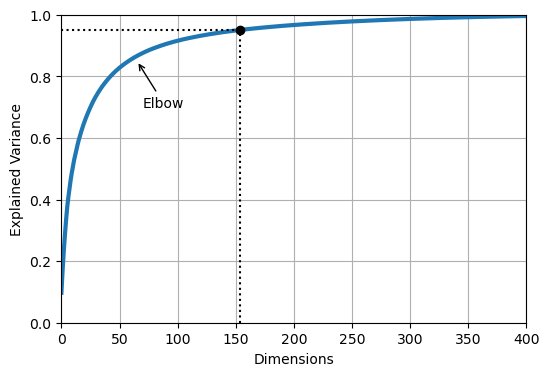

In [18]:

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
# save_fig("explained_variance_plot")
plt.show()

Lastly if you are using dimensionality reduction as a preprocessing step for a supervised learning task (e.g. classification), then you can tune the number of dimensions as you would any other hyperparameter. For e.g.:-

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

# the following code creates a two-step pipeline, first reducing dimensionality
# using PCA, then classifying using a random forest
# Next it uses RandomizedSearchCV to find a good combination of hyperparameters
# for both PCA and RandomForestClassifier
clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [20]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


It’s interesting to note how low the optimal number of components is: we reduced a 784-dimensional dataset to just 23 dimensions! This is tied to the fact that we used a random forest, which is a pretty powerful model.

**PCA for Compression**

After dimensionality reduction, the training set takes up much less space. For example, after applying PCA to the MNIST dataset while preserving 95% of its variance, we are left with 154 features, instead of the original 784 features. So the dataset is now less than 20% of its original size, and we only lost 5% of its variance! This is a reasonable compression ratio, and it’s easy to see how such a size reduction would speed up a classification algorithm tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. This won’t give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

In [21]:
# The inverse_transform() method lets us decompress the reduced MNIST dataset
# back to 784 dimensions:
X_recovered = pca.inverse_transform(X_reduced)

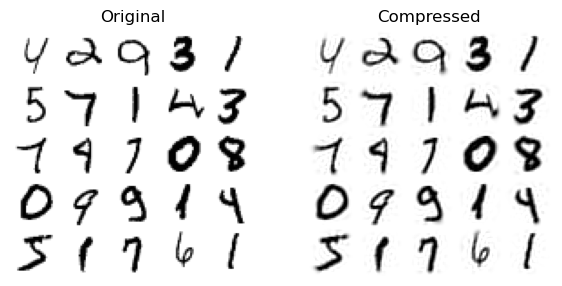

In [22]:
# extra code – this cell generates and saves Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

# save_fig("mnist_compression_plot")

Above figure shows a few digits from the original training set (on the left), and the corresponding digits after compression and decompression. You can see that there is a slight image quality loss, but the digits are still mostly intact

**Randomized PCA**

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called randomized PCA that quickly finds an approximation of the first d principal components.

In [23]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

**Incremental PCA**

One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, incremental PCA (IPCA) algorithms have been developed that allow you to split the training set into mini-batches and feed these in one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

In [24]:
# The following code splits the MNIST training set into 100 mini-batches
# (using Num‐Py’s array_split() function) and feeds them to Scikit-Learn’s
# IncrementalPCA class to reduce the dimensionality of the MNIST dataset
# down to 154 dimensions
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

Alternatively, you can use NumPy’s memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory.

In [25]:
# To demonstrate this, let’s first create a memory-mapped (memmap) file
# and copy the MNIST training set to it, then call flush() to ensure that
# any data still in the cache gets saved to disk. In real
# life, X_train would typically not fit in memory, so you would load it
# chunk by chunk and save each chunk to the right part of the memmap array:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train # could be a loop instead, saving the data chunk by chunk
X_mmap.flush

<bound method memmap.flush of memmap([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [26]:
# Next, we can load the memmap file and use it like a regular NumPy array.
# Let’s use the IncrementalPCA class to reduce its dimensionality.
# Since this algorithm uses only a small part of the array at any given time,
# memory usage remains under control.
# This makes it possible to call the usual fit() method instead of partial_fit(),
# which is quite convenient:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

For very high-dimensional datasets, PCA can be too slow. As you saw earlier, even if you use randomized PCA its computational complexity is still $O(m × d^2) + O(d^3)$, so the target number of dimensions d must not be too large. If you are dealing with a dataset with tens of thousands of features or more (e.g., images), then training may become much too slow: in this case, you should consider using random projection instead.

**Random Projection**

As the name suggests, random projection projects the data to a lower dimension using a random linear projection
- it sounds crazy but it turns out that its very likely to preserve distances fairly well
- how to choose the right number of dimensions without losing too much info?
  - use johnson lindenstrauss equation
  - if you have a dataset containing _m_ = 5000 instances with n = _20000_ features each
  - and you dont want to the squared distance between any two instances to change by more than $\epsilon = 10%$, then the equation reduces it down to 7300 dimensions which is quite a significant reduction!

In [27]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

Now we can just generate a random matrix P of shape [d, n], where each item is sampled randomly from a Gaussian distribution with mean 0 and variance 1 / d, and use it to project a dataset from n dimensions down to d:

In [28]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d) # std dev = square root of variance

X = np.random.randn(m, n) # generate a fake dataset
X_reduced = X @ P.T

It’s simple and efficient, and no training is required: the only thing the algorithm needs to create the random matrix is the dataset’s shape. The data itself is not used at all.

Scikit-Learn offers a `GaussianRandomProjectio`n class to do exactly what we just did: when you call its `fit()` method, it uses `johnson_lindenstrauss_min_dim()` to determine the output dimensionality, then it generates a random matrix, which it stores in the `components_` attribute. 

Then when you call `transform()`, it uses this matrix to perform the projection. When creating the transformer, you can set `eps` if you want to tweak _ε_ (it defaults to 0.1), and `n_components` if you want to force a
specific target dimensionality _d_.

In [ ]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X) # same result as above

Scikit-Learn also provides a second random projection transformer, known as
SparseRandomProjection. Its faster, uses less memory and produces a random matrix that is sparse, so if the input is sparse then the transformation keeps it sparse. In short its usually preferred to use this one especially for large or sparse datasets.

LSH refers to a family of functions (known as LSH families) to hash data points into buckets so that data points near each other are located in the same buckets with high probability, while data points far from each other are likely to be in different buckets. So its like dimensionality reduction that using hashing rather than using random projection.

**LLE**

Locally linear embedding (LLE) is a _nonlinear dimensionality reduction_ (NLDR) technique. It is a manifold learning technique that does not rely on projections, unlike PCA and random projection.
- it works by measuring how each training instance linearly relates to its nearest neighbours
- then it looking for a low-dimensional representation of the training set where these local relationships are best preserved
- this makes it particularly good at unrolling twisted manifolds, especially when there isnt too much noise


In [ ]:
#The following code makes a Swiss roll,
# then uses Scikit-Learn’s LocallyLinearEmbed ding class to unroll it:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

In [ ]:
# extra code – this cell generates and saves Figure 8–10

plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

# save_fig("lle_unrolling_plot")
plt.title("Unrolled swiss roll using LLE")
plt.show()

However, distances are not preserved on a larger scale: the unrolled Swiss roll should be a rectangle, not this kind of stretched and twisted band. Nevertheless, LLE did a pretty good job of modeling the manifold

LLE is quite different from the projection techniques, and it’s significantly
more complex, but it can also construct much better low-dimensional representations, especially if the data is nonlinear.